In [1]:
#from comet_ml import Experiment
import os
import random
import time
import glob
import shutil
import warnings

import cv2
import scipy
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import albumentations as A #albumentations -> biblioteca focada em imagens 
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from albumentations.pytorch import ToTensor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid, save_image


%matplotlib inline
warnings.filterwarnings('ignore', category=FutureWarning)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Settings

In [2]:
config = {'DataLoader': {'batch_size': 64, #tamanho do lote
                         'shuffle': True}, #embaralhar
          'Generator': {'latent_dim': 120, #dimensoes do vetor de ruido
                        'embed_dim': 32,   #
                        'ch': 64,          #quantidade de canais
                        'num_classes': 120,#quantidade de classes
                        'use_attn': True}, 
          'Discriminator': {'ch': 64,           #quantidade de canais
                            'num_classes': 120, #quantidade de classes
                            'use_attn': True},
          'sample_latents': {'latent_dim': 120,
                             'num_classes': 120}, 
          'num_iterations': 100000,             #numero de interações
          'decay_start_iteration': 100000,   
          'd_steps': 1,                        #
          'lr_G': 2e-4,                        #taxa de aprendizado do Gerador
          'lr_D': 4e-4,                        #taxa de aprendizado do Discriminador
          'betas': (0.0, 0.999),               
          'margin': 1.0,
          'gamma': 0.1,
          'ema': 0.999,
          'seed': 42}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(config['seed'])

# Data Processing

## Load Data

In [4]:
root_images = './input/all-dogs/all-dogs/'
root_annots = './input/annotation/Annotation/'

In [5]:
all_files = os.listdir(root_images)

In [6]:
breeds = glob.glob(root_annots+'*')
annotations = []
for breed in breeds:
    annotations += glob.glob(breed+'/*')

In [7]:
breed_map = {}
for annotation in annotations:
    breed = annotation.split('/')[-2]
    index = breed.split('-')[0]
    breed_map.setdefault(index, breed)

In [8]:
all_labels = [breed_map[file.split('_')[0]] for file in all_files]
le = LabelEncoder()
all_labels = le.fit_transform(all_labels)

In [9]:
def load_bbox(file):
    file = str(breed_map[file.split('_')[0]]) + '/' + str(file.split('.')[0])
    path = os.path.join(root_annots, file)
    tree = ET.parse(path)
    root = tree.getroot()
    objects = root.findall('object')
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
    
    return (xmin, ymin, xmax, ymax)

In [10]:
all_bboxes = [load_bbox(file) for file in all_files]

In [11]:
print('Total files       : {}'.format(len(all_files)))
print('Total labels      : {}'.format(len(all_labels)))
print('Total bboxes      : {}'.format(len(all_bboxes)))
print('Total annotations : {}'.format(len(annotations)))
print('Total classes     : {}'.format(len(le.classes_)))

Total files       : 20579
Total labels      : 20579
Total bboxes      : 20579
Total annotations : 20580
Total classes     : 120


In [12]:
print(le.classes_)

['n02085620-Chihuahua' 'n02085782-Japanese_spaniel'
 'n02085936-Maltese_dog' 'n02086079-Pekinese' 'n02086240-Shih-Tzu'
 'n02086646-Blenheim_spaniel' 'n02086910-papillon' 'n02087046-toy_terrier'
 'n02087394-Rhodesian_ridgeback' 'n02088094-Afghan_hound'
 'n02088238-basset' 'n02088364-beagle' 'n02088466-bloodhound'
 'n02088632-bluetick' 'n02089078-black-and-tan_coonhound'
 'n02089867-Walker_hound' 'n02089973-English_foxhound' 'n02090379-redbone'
 'n02090622-borzoi' 'n02090721-Irish_wolfhound'
 'n02091032-Italian_greyhound' 'n02091134-whippet'
 'n02091244-Ibizan_hound' 'n02091467-Norwegian_elkhound'
 'n02091635-otterhound' 'n02091831-Saluki' 'n02092002-Scottish_deerhound'
 'n02092339-Weimaraner' 'n02093256-Staffordshire_bullterrier'
 'n02093428-American_Staffordshire_terrier' 'n02093647-Bedlington_terrier'
 'n02093754-Border_terrier' 'n02093859-Kerry_blue_terrier'
 'n02093991-Irish_terrier' 'n02094114-Norfolk_terrier'
 'n02094258-Norwich_terrier' 'n02094433-Yorkshire_terrier'
 'n02095314-w

In [13]:
# make square bounding boxes of original ones,
# to keep a dog's aspect ratio.

def get_resized_bbox(height, width, bbox):
    xmin, ymin, xmax, ymax = bbox
    xlen = xmax - xmin
    ylen = ymax - ymin
    
    if xlen > ylen:
        diff = xlen - ylen
        min_pad = min(ymin, diff//2)
        max_pad = min(height-ymax, diff-min_pad)
        ymin = ymin - min_pad
        ymax = ymax + max_pad

    elif ylen > xlen:
        diff = ylen - xlen
        min_pad = min(xmin, diff//2)
        max_pad = min(width-xmax, diff-min_pad)
        xmin = xmin - min_pad
        xmax = xmax + max_pad
    
    return xmin, ymin, xmax, ymax

In [14]:
resized_bboxes = []
for file, bbox in zip(all_files, all_bboxes):
    img = Image.open(os.path.join(root_images, file))
    width, height = img.size
    xmin, ymin, xmax, ymax = get_resized_bbox(height, width, bbox)
    resized_bboxes.append((xmin, ymin, xmax, ymax))

In [15]:
# crop by square bounding box -> resize and normalize.
# cv2.INTER_AREA is better than others.

def load_bboxcrop_resized_image(file, bbox):
    img = cv2.imread(os.path.join(root_images, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    xmin, ymin, xmax, ymax = bbox
    img = img[ymin:ymax,xmin:xmax]

    transform = A.Compose([A.Resize(64, 64, interpolation=cv2.INTER_AREA),
                           A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    img = transform(image=img)['image']
    
    return img

In [16]:
all_images = [load_bboxcrop_resized_image(f, b) for f, b in zip(all_files, resized_bboxes)]
all_images = np.array(all_images)

In [17]:
class DogDataset(Dataset):
    def __init__(self, images, labels):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = A.Compose([A.HorizontalFlip(p=0.5), ToTensor()])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        img = self.transform(image=img)['image']
        label = torch.as_tensor(label, dtype=torch.long)

        return img, label

In [18]:
# adding uniform noise works well.

def get_dataiterator(images, labels, dataloader_params, device='cpu'):
    train_dataset = DogDataset(images, labels)
    train_dataloader = DataLoader(train_dataset, **dataloader_params)

    while True:
        for imgs, labels in train_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs += (1.0 / 128.0) * torch.rand_like(imgs)

            yield imgs, labels

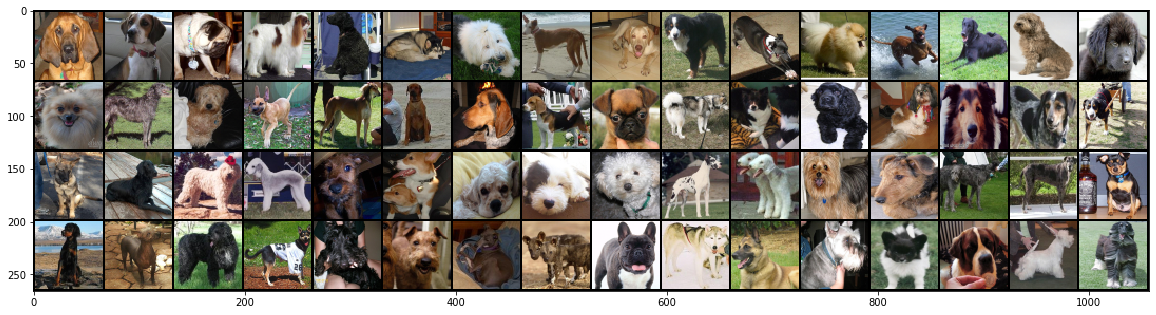

In [19]:
train_dataiterator = get_dataiterator(all_images, all_labels, config['DataLoader'])

imgs, _ = train_dataiterator.__next__()
imgs = (imgs + 1) / 2
imgs = make_grid(imgs, nrow=16, normalize=False)
imgs = imgs.mul_(255).add_(0.5).clamp_(0, 255).permute(1,2,0).to(torch.uint8).numpy()

plt.figure(figsize=(20,10))
plt.imshow(imgs);

# Models

In [20]:
# Attention slightly works.

class Attention(nn.Module):
    def __init__(self, channels, reduction_attn=8, reduction_sc=2):
        super().__init__()
        self.channles_attn = channels // reduction_attn
        self.channels_sc = channels // reduction_sc
        
        self.conv_query = spectral_norm(nn.Conv2d(channels, self.channles_attn, kernel_size=1, bias=False))
        self.conv_key = spectral_norm(nn.Conv2d(channels, self.channles_attn, kernel_size=1, bias=False))
        self.conv_value = spectral_norm(nn.Conv2d(channels, self.channels_sc, kernel_size=1, bias=False))
        self.conv_attn = spectral_norm(nn.Conv2d(self.channels_sc, channels, kernel_size=1, bias=False))
        self.gamma = nn.Parameter(torch.zeros(1))
        
        nn.init.orthogonal_(self.conv_query.weight.data)
        nn.init.orthogonal_(self.conv_key.weight.data)
        nn.init.orthogonal_(self.conv_value.weight.data)
        nn.init.orthogonal_(self.conv_attn.weight.data)

    def forward(self, x):
        batch, _, h, w = x.size()
        
        proj_query = self.conv_query(x).view(batch, self.channles_attn, -1)
        proj_key = F.max_pool2d(self.conv_key(x), 2).view(batch, self.channles_attn, -1)
        
        attn = torch.bmm(proj_key.permute(0,2,1), proj_query)
        attn = F.softmax(attn, dim=1)
        
        proj_value = F.max_pool2d(self.conv_value(x), 2).view(batch, self.channels_sc, -1)
        attn = torch.bmm(proj_value, attn)
        attn = attn.view(batch, self.channels_sc, h, w)
        attn = self.conv_attn(attn)
        
        out = self.gamma * attn + x
        
        return out

## Generator

In [21]:
# using label information works well.
# As for generator, it is realized by conditional batch normalization.  

class CBN2d(nn.Module):
    def __init__(self, num_features, num_conditions):
        super().__init__()
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = spectral_norm(nn.Conv2d(num_conditions, num_features*2, kernel_size=1, bias=False))
        
        nn.init.orthogonal_(self.embed.weight.data)

    def forward(self, x, y):
        out = self.bn(x)
        embed = self.embed(y.unsqueeze(2).unsqueeze(3))
        gamma, beta = embed.chunk(2, dim=1)
        out = (1.0 + gamma) * out + beta 

        return out

In [22]:
# residual block improves convergence speed and generated image's quality.
# nearest upsampling is better than others.

class GBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conditions, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.learnable_sc = in_channels != out_channels or upsample
        
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.cbn1 = CBN2d(in_channels, num_conditions)
        self.cbn2 = CBN2d(out_channels, num_conditions)
        if self.learnable_sc:
            self.conv_sc = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False))
        self.relu = nn.ReLU()

        nn.init.orthogonal_(self.conv1.weight.data)
        nn.init.orthogonal_(self.conv2.weight.data)
        if self.learnable_sc:
            nn.init.orthogonal_(self.conv_sc.weight.data)
    
    def _upsample_conv(self, x, conv):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = conv(x)
        
        return x
    
    def _residual(self, x, y):
        x = self.relu(self.cbn1(x, y))
        x = self._upsample_conv(x, self.conv1) if self.upsample else self.conv1(x)
        x = self.relu(self.cbn2(x, y))
        x = self.conv2(x)
        
        return x
    
    def _shortcut(self, x):
        if self.learnable_sc:
            x = self._upsample_conv(x, self.conv_sc) if self.upsample else self.conv_sc(x)
            
        return x
    
    def forward(self, x, y):
        return self._shortcut(x) + self._residual(x, y)

In [23]:
# shared embedding of class labels, and hierarchical latent noise, work well.
# this architecture is the same as BigGAN except for channel size.

class Generator(nn.Module):
    def __init__(self, latent_dim, ch, num_classes, embed_dim, use_attn=False):
        super().__init__()
        self.latent_dim = latent_dim
        self.ch = ch
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.use_attn = use_attn
        self.num_chunk = 5
        num_latents = self.__get_num_latents()
        
        self.embed = nn.Embedding(num_classes, embed_dim)
        self.fc = spectral_norm(nn.Linear(num_latents[0], ch*8*4*4, bias=False))
        self.block1 = GBlock(ch*8, ch*8, num_latents[1], upsample=True)
        self.block2 = GBlock(ch*8, ch*4, num_latents[2], upsample=True)
        self.block3 = GBlock(ch*4, ch*2, num_latents[3], upsample=True)
        if use_attn:
            self.attn = Attention(ch*2)
        self.block4 = GBlock(ch*2, ch, num_latents[4], upsample=True)
        self.bn = nn.BatchNorm2d(ch)
        self.relu = nn.ReLU()
        self.conv_last = spectral_norm(nn.Conv2d(ch, 3, kernel_size=3, padding=1, bias=False))
        self.tanh = nn.Tanh()
        
        nn.init.orthogonal_(self.embed.weight.data)
        nn.init.orthogonal_(self.fc.weight.data)
        nn.init.orthogonal_(self.conv_last.weight.data)
        nn.init.constant_(self.bn.weight.data, 1.0)
        nn.init.constant_(self.bn.bias.data, 0.0)
    
    def __get_num_latents(self):
        xs = torch.empty(self.latent_dim).chunk(self.num_chunk)
        num_latents = [x.size(0) for x in xs]
        for i in range(1, self.num_chunk):
            num_latents[i] += self.embed_dim
        
        return num_latents
    
    def forward(self, x, y):
        xs = x.chunk(self.num_chunk, dim=1)
        y = self.embed(y)
        
        h = self.fc(xs[0])
        h = h.view(h.size(0), self.ch*8, 4, 4)
        h = self.block1(h, torch.cat([y, xs[1]], dim=1))
        h = self.block2(h, torch.cat([y, xs[2]], dim=1))
        h = self.block3(h, torch.cat([y, xs[3]], dim=1))
        if self.use_attn:
            h = self.attn(h)
        h = self.block4(h, torch.cat([y, xs[4]], dim=1))
        h = self.relu(self.bn(h))
        out = self.tanh(self.conv_last(h))
        
        return out

## Discriminator

In [24]:
# residual block improves convergence speed and generated image's quality.

class DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, optimized=False):
        super().__init__()
        self.downsample = downsample
        self.optimized = optimized
        self.learnable_sc = in_channels != out_channels or downsample
        
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))
        if self.learnable_sc:
            self.conv_sc = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False))
        self.relu = nn.ReLU()
        
        nn.init.orthogonal_(self.conv1.weight.data)
        nn.init.orthogonal_(self.conv2.weight.data)
        if self.learnable_sc:
            nn.init.orthogonal_(self.conv_sc.weight.data)
    
    def _residual(self, x):
        if not self.optimized:
            x = self.relu(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        
        return x
    
    def _shortcut(self, x):
        if self.learnable_sc:
            if self.optimized:
                x = self.conv_sc(F.avg_pool2d(x, 2)) if self.downsample else self.conv_sc(x)
            else:
                x = F.avg_pool2d(self.conv_sc(x), 2) if self.downsample else self.conv_sc(x)
        
        return x
    
    def forward(self, x):
        return self._shortcut(x) + self._residual(x)

In [25]:
# this architecture is the altered version of BigGAN Discriminator.
# <- using residual block, projection.

# but those points are different from original.
# - reduce channel size.
# - reduce model depth (remove last residual block).
# - with auxiliary classifier (ACGAN).
#   <- improve image's quality and stabilize training.

class Discriminator(nn.Module):
    def __init__(self, ch, num_classes, use_attn=False):
        super().__init__()
        self.ch = ch
        self.num_classes = num_classes
        self.use_attn = use_attn
        
        self.block1 = DBlock(3, ch, downsample=True, optimized=True)
        if use_attn:
            self.attn = Attention(ch)
        self.block2 = DBlock(ch, ch*2, downsample=True)
        self.block3 = DBlock(ch*2, ch*4, downsample=True)
        self.block4 = DBlock(ch*4, ch*8, downsample=True)
        self.relu = nn.ReLU()
        self.fc = spectral_norm(nn.Linear(ch*8, 1, bias=False))
        self.embed = spectral_norm(nn.Embedding(num_classes, ch*8))
        self.clf = spectral_norm(nn.Linear(ch*8, num_classes, bias=False))
        
        nn.init.orthogonal_(self.fc.weight.data)
        nn.init.orthogonal_(self.embed.weight.data)
        nn.init.orthogonal_(self.clf.weight.data)
    
    def forward(self, x, y):
        h = self.block1(x)
        if self.use_attn:
            h = self.attn(h)
        h = self.block2(h)
        h = self.block3(h)
        h = self.block4(h)
        h = self.relu(h)
        h = torch.sum(h, dim=(2,3))
        
        out = self.fc(h)
        out += torch.sum(self.embed(y)*h, dim=1, keepdim=True)
        
        ac = self.clf(h)
        ac = F.log_softmax(ac, dim=1)
        
        return out, ac

# Train GANs

In [26]:
experiment = Experiment(api_key="PHAxi2jkAeo0LSm70QBuQTVxZ",
                        project_name="general", workspace="karl-marcus")
hyper_params = {"learning_rate": 2e-4, "steps": 50000, "batch_size": 64}
experiment.log_parameters(hyper_params)

COMET INFO: old comet version (2.0.15) detected. current: 2.0.17 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/karl-marcus/general/87173eefff34489fb6a9eebc31df182a



In [27]:
# batch size around 64 ~ 128 improves score.
# ~ 64 are too small, 128 ~ are too large (for 9 hours training). 

train_dataiterator = get_dataiterator(all_images, all_labels, config['DataLoader'], device=device)

In [28]:
netG = Generator(**config['Generator']).to(device, torch.float32)
netD = Discriminator(**config['Discriminator']).to(device, torch.float32)

In [29]:
# Exponential moving average of generator weights works well.

netGE = Generator(**config['Generator']).to(device, torch.float32)
netGE.load_state_dict(netG.state_dict());

In [30]:
optim_G = Adam(params=netG.parameters(), lr=config['lr_G'], betas=config['betas'])
optim_D = Adam(params=netD.parameters(), lr=config['lr_D'], betas=config['betas'])

In [31]:
decay_iter = config['num_iterations'] - config['decay_start_iteration']
if decay_iter > 0:
    lr_lambda_G = lambda x: (max(0,1-x/decay_iter))
    lr_lambda_D = lambda x: (max(0,1-x/(decay_iter*config['d_steps'])))
    lr_sche_G = LambdaLR(optim_G, lr_lambda=lr_lambda_G)
    lr_sche_D = LambdaLR(optim_D, lr_lambda=lr_lambda_D)

In [32]:
def calc_advloss_D(real, fake, margin=1.0):
    loss_real = torch.mean((real - fake.mean() - margin) ** 2)
    loss_fake = torch.mean((fake - real.mean() + margin) ** 2)
    loss = (loss_real + loss_fake) / 2
    
    return loss

In [33]:
def calc_advloss_G(real, fake, margin=1.0):
    loss_real = torch.mean((real - fake.mean() + margin) ** 2)
    loss_fake = torch.mean((fake - real.mean() - margin) ** 2)
    loss = (loss_real + loss_fake) / 2
    
    return loss

In [34]:
# auxiliary classifier loss.
# this loss weighted by gamma (0.1) is added to adversarial loss.
# coefficient gamma is quite sensitive.

criterion = nn.NLLLoss().to(device, torch.float32)

In [35]:
def sample_latents(batch_size, latent_dim, num_classes):
    latents = torch.randn((batch_size, latent_dim), dtype=torch.float32, device=device)
    labels = torch.randint(0, num_classes, size=(batch_size,), dtype=torch.long, device=device)
    
    return latents, labels

In [36]:
def truncated_normal(size, threshold=2.0, dtype=torch.float32, device='cpu'):
    x = scipy.stats.truncnorm.rvs(-threshold, threshold, size=size)
    x = torch.from_numpy(x).to(device, dtype)

    return x

In [37]:
def generate_eval_samples(generator, batch_size, latent_dim, num_classes):
    latents = truncated_normal((batch_size, latent_dim), dtype=torch.float32, device=device)
    labels =  torch.randint(0, num_classes, size=(batch_size,), dtype=torch.long, device=device)
    
    with torch.no_grad():
        imgs = (generator(latents, labels) + 1) / 2
    
    return imgs

In [38]:
def make_submissions(generator, user_images_unzipped_path, latent_dim, num_classes):
    if not os.path.exists(user_images_unzipped_path):
        os.mkdir(user_images_unzipped_path)
    
    sample_batch_size = 50
    num_samples = 10000
    
    for i in range(0, num_samples, sample_batch_size):
        imgs = generate_eval_samples(generator, sample_batch_size, latent_dim, num_classes)
        for j, img in enumerate(imgs):
            save_image(img, os.path.join(user_images_unzipped_path, f'image_{i+j:05d}.png'))
    
    shutil.make_archive('images', 'zip', user_images_unzipped_path)

In [2]:
from __future__ import absolute_import, division, print_function
import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image

class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

def _get_model_layer(sess, model_name):
    # layername = 'Pretrained_Net/final_layer/Mean:0'
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
              shape = [s.value for s in shape]
              new_shape = []
              for j, s in enumerate(shape):
                if s == 1 and j == 0:
                  new_shape.append(None)
                else:
                  new_shape.append(s)
              o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer

def get_activations(images, sess, model_name, batch_size=64, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr


# def calculate_memorization_distance(features1, features2):
#     neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', metric='euclidean')
#     neigh.fit(features2) 
#     d, _ = neigh.kneighbors(features1, return_distance=True)
#     print('d.shape=',d.shape)
#     return np.mean(d)

def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    # print('rows of zeros in features1 = ',sum(np.sum(features1, axis=1) == 0))
    # print('rows of zeros in features2 = ',sum(np.sum(features2, axis=1) == 0))
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=',d.shape)
    print('np.min(d, axis=1).shape=',np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=',mean_min_d)
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        # covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    # covmean = tf.linalg.sqrtm(tf.linalg.matmul(sigma1,sigma2))

    print('covmean.shape=',covmean.shape)
    # tr_covmean = tf.linalg.trace(covmean)

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    # return diff.dot(diff) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean
#-------------------------------------------------------------------------------


def calculate_activation_statistics(images, sess, model_name, batch_size=50, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act
    
def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features

# check for image size
def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None, mm=[], ss=[], ff=[]):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True)
        if len(mm) != 0:
            m2 = mm
            s2 = ss
            features2 = ff
        elif feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
        print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance, m2, s2, features2

In [40]:
step = 1

while True:
    # Discriminator
    for i in range(config['d_steps']):
        for param in netD.parameters():
            param.requires_grad_(True)
    
        optim_D.zero_grad()

        real_imgs, real_labels = train_dataiterator.__next__()
        batch_size = real_imgs.size(0)

        latents, fake_labels = sample_latents(batch_size, **config['sample_latents'])
        fake_imgs = netG(latents, fake_labels).detach()
        
        preds_real, preds_real_labels = netD(real_imgs, real_labels)
        preds_fake, _ = netD(fake_imgs, fake_labels)

        loss_D = calc_advloss_D(preds_real, preds_fake, config['margin'])
        loss_D += config['gamma'] * criterion(preds_real_labels, real_labels)
        loss_D.backward()
        optim_D.step()
        
        if (decay_iter > 0) and (step > config['decay_start_iteration']):
            lr_sche_D.step()

    # Generator
    for param in netD.parameters():
        param.requires_grad_(False)

    optim_G.zero_grad()
    
    real_imgs, real_labels = train_dataiterator.__next__()
    batch_size = real_imgs.size(0)
    
    latents, fake_labels = sample_latents(batch_size, **config['sample_latents'])
    fake_imgs = netG(latents, fake_labels)

    preds_real, _ = netD(real_imgs, real_labels)
    preds_fake, preds_fake_labels = netD(fake_imgs, fake_labels)

    loss_G = calc_advloss_G(preds_real, preds_fake, config['margin'])
    loss_G += config['gamma'] * criterion(preds_fake_labels, fake_labels)
    loss_G.backward()
    optim_G.step()
    
    if (decay_iter > 0) and (step > config['decay_start_iteration']):
        lr_sche_G.step()
    
    # Update Generator Eval
    for param_G, param_GE in zip(netG.parameters(), netGE.parameters()):
        param_GE.data.mul_(config['ema']).add_((1-config['ema'])*param_G.data)
    for buffer_G, buffer_GE in zip(netG.buffers(), netGE.buffers()):
        buffer_GE.data.mul_(config['ema']).add_((1-config['ema'])*buffer_G.data)
        
    experiment.log_metric("Loss_D", loss_D.cpu().detach().numpy(), step=None, epoch=None, include_context=True)    
    experiment.log_metric("Loss_G", loss_G.cpu().detach().numpy(), step=None, epoch=None, include_context=True)    
            
           
    if step % 5000 == 0:
        
        print('total step: {}'.format(step))
        
        #Generate Images
        user_images_unzipped_path = './output_images' + str(step) + '/'
        make_submissions(netGE, user_images_unzipped_path, **config['sample_latents'])
        
        #Compute FID
        m2 = []; s2 =[]; f2 = []
        user_images_unzipped_path = './output_images' + str(step) + '/'
        images_path = [user_images_unzipped_path,'input/all-dogs/all-dogs/']
        public_path = 'dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'

        fid_epsilon = 10e-15

        fid_value_public, distance_public, m2, s2, f2 = calculate_kid_given_paths(images_path, 'Inception', public_path, mm=m2, ss=s2, ff=f2)
        distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
        print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ",
            fid_value_public /(distance_public + fid_epsilon))
        
        
        experiment.log_metric("FID", fid_value_public, step=None, epoch=None, include_context=True)    
        
        print('\n')
        
    if step < config['num_iterations']:
        step += 1
    
     # stopping    
    if step == config['num_iterations']:    
        break

total step: 5000
Instructions for updating:
Use tf.gfile.GFile.


100%|██████████| 412/412 [23:20<00:00,  3.18s/it]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.21445427132327397
FID_public:  73.35498719446832 distance_public:  1 multiplied_public:  73.35498719446758


total step: 10000


100%|██████████| 412/412 [22:49<00:00,  2.91s/it]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.1905613425668873
FID_public:  39.901227440778825 distance_public:  1 multiplied_public:  39.90122744077843


total step: 15000


100%|██████████| 412/412 [22:20<00:00,  2.85s/it]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.17957196473698087
FID_public:  28.567679170480346 distance_public:  1 multiplied_public:  28.567679170480062


total step: 20000


100%|██████████| 412/412 [22:21<00:00,  2.85s/it]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.17133920370746977
FID_public:  23.09485752226749 distance_public:  1 multiplied_public:  23.094857522267258


total step: 25000


100%|██████████| 412/412 [22:24<00:00,  2.86s/it]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.16741785649725585
FID_public:  20.19257639706592 distance_public:  1 multiplied_public:  20.192576397065718


total step: 30000


100%|██████████| 412/412 [22:26<00:00,  2.86s/it]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.16229642889286558
FID_public:  17.953326376218968 distance_public:  1 multiplied_public:  17.95332637621879


total step: 35000


100%|██████████| 412/412 [22:24<00:00,  2.87s/it]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.16151611711002198
FID_public:  17.73997730855814 distance_public:  1 multiplied_public:  17.73997730855796


total step: 40000


100%|██████████| 412/412 [25:07<00:00,  3.35s/it]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.1604449530616247
FID_public:  17.130426621231948 distance_public:  1 multiplied_public:  17.130426621231777


total step: 45000


100%|██████████| 412/412 [25:56<00:00,  3.34s/it]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.15851780232119314
FID_public:  16.711657397816225 distance_public:  1 multiplied_public:  16.711657397816058


total step: 50000


100%|██████████| 412/412 [22:51<00:00,  2.89s/it]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.1571209042317826
FID_public:  16.499725272741216 distance_public:  1 multiplied_public:  16.499725272741053


total step: 55000


100%|██████████| 412/412 [25:22<00:00,  3.14s/it]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.1564862093951682
FID_public:  16.44494118273633 distance_public:  1 multiplied_public:  16.444941182736166


total step: 60000


100%|██████████| 412/412 [25:46<00:00,  3.17s/it]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.157608819290925
FID_public:  16.57921561550569 distance_public:  1 multiplied_public:  16.57921561550552


total step: 65000


100%|██████████| 412/412 [25:10<00:00,  3.41s/it]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation


MemoryError: Unable to allocate array with shape (10000, 20579) and data type float64

In [3]:
m2 = []; s2 =[]; f2 = []
user_images_unzipped_path = './output_images' + str(65000) + '/'
images_path = [user_images_unzipped_path,'input/all-dogs/all-dogs/']
public_path = 'dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'

fid_epsilon = 10e-15

fid_value_public, distance_public, m2, s2, f2 = calculate_kid_given_paths(images_path, 'Inception', public_path, mm=m2, ss=s2, ff=f2)
distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ",fid_value_public /(distance_public + fid_epsilon))
        

Instructions for updating:
Use tf.gfile.GFile.


100%|██████████| 412/412 [22:34<00:00,  2.87s/it]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.15857871823568062
FID_public:  16.551155283167645 distance_public:  1 multiplied_public:  16.55115528316748
